In [1]:
# # Code to download file into Colaboratory:
# !pip install -U -q PyDrive > /dev/null
# !pip install torchmetrics > /dev/null
# from pydrive.auth import GoogleAuth
# import torch
# dev = "cuda" if torch.cuda.is_available() else "cpu"
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# #get the data from the drive
# def get_feature(model = "ViT-L/14@336px"):
#   id = '11yXddz5j-IDcH77wkMF7dW2JctRv7YN6'
#   size = "B"

#   if model == 'ViT-L/14@336px':
#     id = '1P6CgrgiIACjnhtHsUwdY8qjZ-E3Vx_0x'
#     size = "L336"
#   elif model == 'ViT-L/14':
#     id = '1DG4J-YF57ZsfXTzwg5EFfkzUmUFfr82h'
#     size = "L"
#   elif model == 'ViT-B/32':
#     id = '11yXddz5j-IDcH77wkMF7dW2JctRv7YN6'
#     size = "B"

#   downloaded = drive.CreateFile({'id':id}) 
#   downloaded.GetContentFile('clip_features.zip')

#   #get the data from the drive
#   id = '1b-ujWaLM_jOzlRMbXVb9T-3oEibKQW1r'
#   downloaded = drive.CreateFile({'id':id}) 
#   downloaded.GetContentFile('label_onehot_tensor.pt')

#   !unzip clip_features.zip > /dev/null

#   test_image_features = torch.load(f"test_image_features_vit{size}.pt")
#   test_text_feature = torch.load(f"test_text_feature_vit{size}.pt")
#   all_image_features = torch.load(f"all_image_features_vit{size}.pt")
#   all_text_feature = torch.load(f"all_text_feature_vit{size}.pt")
#   label_onehot_tensor = torch.load(f"label_onehot_tensor.pt")

#   return all_image_features, all_text_feature, test_image_features, test_text_feature, label_onehot_tensor

In [2]:
# all_image_features, all_text_feature, test_image_features, test_text_feature, label_onehot_tensor = get_feature()

In [3]:
# import torch
# dev = "cuda" if torch.cuda.is_available() else "cpu"
# test_image_features = torch.load("test_image_features_vitL.pt", map_location = torch.device(dev))
# test_text_feature = torch.load("test_text_feature_vitL.pt", map_location = torch.device(dev))
# all_image_features = torch.load("all_image_features_vitL.pt", map_location = torch.device(dev))
# all_text_feature = torch.load("all_text_feature_vitL.pt", map_location = torch.device(dev))
# label_onehot_tensor = torch.load("label_onehot_tensor.pt", map_location = torch.device(dev))

In [4]:
import torch
dev = "cuda" if torch.cuda.is_available() else "cpu"
test_image_features = torch.load("../features/test_image_features_vitL.pt", map_location = torch.device(dev))
test_text_feature = torch.load("../features/test_text_feature_vitL.pt", map_location = torch.device(dev))
all_image_features = torch.load("../features/all_image_features_vitL.pt", map_location = torch.device(dev))
all_text_feature = torch.load("../features/all_text_feature_vitL.pt", map_location = torch.device(dev))
label_onehot_tensor = torch.load("../features/label_onehot_tensor.pt", map_location = torch.device(dev))

In [5]:
test_image_features.shape

torch.Size([10000, 768])

In [6]:
def add_weight_decay(model, weight_decay=1e-4, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [7]:
import torch
import torch.nn as nn


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        
        xs_pos = x
        xs_neg = 1 - x

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))
        
        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()

In [8]:
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torchmetrics import F1Score
from torch import optim
from torch.cuda.amp import GradScaler, autocast

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
def Trainer(model, Data, epochs, epoch_step_1, epoch_step_2, batch_size, lr = 1e-3):
    torch.manual_seed(5329)
    train_data = DataLoader(TensorDataset(Data[:25000], label_onehot_tensor[:25000]), batch_size=batch_size, shuffle = True)
    val_data = DataLoader(TensorDataset(Data[25000:], label_onehot_tensor[25000:].to(torch.int32)), batch_size=5000, shuffle = False)
    
    # Change here to switch to the best setting
    # train_data = DataLoader(TensorDataset(Data, label_onehot_tensor), batch_size=30000, shuffle = True)
    
    model = model.to(dev)
 
    weight_decay = 2e-4
    criterion = AsymmetricLoss(gamma_neg=0, gamma_pos=0, clip=0, disable_torch_grad_focal_loss=True)
    parameters = add_weight_decay(model, weight_decay)
    opti = optim.Adam(params=parameters, lr=lr, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opti, milestones=[epoch_step_1,epoch_step_2], gamma = 0.1)
    f1 = F1Score(task="multilabel", num_labels = 18).to(dev)

    epoch = epochs
    train_loss = []
    val_loss = []
    f1_list = []
    scaler = GradScaler()
    
    for epoch in tqdm(range(epoch), colour = 'GREEN'):
        for data, label in train_data:   
            data, label = data.to(dev), label.to(dev)

            with autocast():  # mixed precision
                output = model(data).float() 

            loss = criterion(output, label)
            model.zero_grad()
            
            scaler.scale(loss).backward()
            scaler.step(opti)
            scaler.update()
            
        train_loss.append(loss.item())
        
        with torch.autograd.no_grad():
            for data_val, label_val in val_data:
                data_val, label_val = data_val.to(dev), label_val.to(dev)
                predict = model(data_val)
                f1_score = f1(predict, label_val)
                v_loss = criterion(predict, label_val)
            val_loss.append(v_loss.item())
            f1_list.append(f1_score.item())
        
        # Comment the code below if you want to switch to the best settings (i.e., no validation data)
        if epoch % 10 == 0:
            print('Validation F1 in epoch{} : {:.4f}'.format(epoch, f1_score.item()))
            print('Validation loss in epoch{} : {:.4f}'.format(epoch, v_loss.item()))
    
    return model, train_loss, val_loss, f1_list

In [9]:
import torch.nn as nn
import torch.nn.functional as F
class FEATURE_EXTRACTOR(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 18)
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, inputs):
        tensor = F.gelu(self.fc1(inputs))
        tensor = self.dropout(tensor)
        tensor = F.gelu(self.fc2(tensor))
        tensor = self.dropout(tensor)
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

class DECISION_MODEL(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(18, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 18)

    def forward(self, inputs):
        tensor = F.gelu(self.fc1(inputs))
        tensor = F.gelu(self.fc2(tensor))
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

## Experiment on Batch Size & Learning Rate

In [10]:
import os
import numpy as np
batch_size = [25000, 10000, 5000]
lr_list = [0.001, 0.01, 0.1]

f1_list = []
val_loss = []
train_loss = []

for i in range(len(batch_size)):
    for j in range(len(lr_list)):
        Net, train_image_loss, val_image_loss, f1_image_list = Trainer(FEATURE_EXTRACTOR(), all_image_features, 200, 100, 150, 
                                                                       batch_size[i], lr_list[j])
        Net.eval()
        with torch.autograd.no_grad():
            img_train = Net(all_image_features.to(dev))
            img_test = Net(test_image_features.to(dev))

        Net, train_text_loss, val_text_loss, f1_text_list = Trainer(FEATURE_EXTRACTOR(), all_text_feature, 200, 100, 150,
                                                                   batch_size[i], lr_list[j])
        Net.eval()
        with torch.autograd.no_grad():
            txt_train = Net(all_text_feature.to(dev))
            txt_test = Net(test_text_feature.to(dev))

        sum_train = img_train + txt_train
        sum_test = img_test + txt_test
        Net, train_sum_loss, val_sum_loss, f1_sum_list = Trainer(DECISION_MODEL(), sum_train, 200, 100, 150,
                                                                batch_size[i], lr_list[j])
        Net.eval()
        
        f1_list.append(f1_sum_list[-1])
        
        train_loss.append(train_sum_loss)
        val_loss.append(val_sum_loss)

  0%|▍                                                                                 | 1/200 [00:00<03:15,  1.02it/s]

Validation F1 in epoch0 : 0.1319
Validation loss in epoch0 : 62567.1562


  6%|████▍                                                                            | 11/200 [00:03<00:52,  3.57it/s]

Validation F1 in epoch10 : 0.1317
Validation loss in epoch10 : 62571.2969


 10%|████████▌                                                                        | 21/200 [00:06<00:52,  3.38it/s]

Validation F1 in epoch20 : 0.5844
Validation loss in epoch20 : 22402.3984


 16%|████████████▌                                                                    | 31/200 [00:09<00:50,  3.37it/s]

Validation F1 in epoch30 : 0.5926
Validation loss in epoch30 : 17358.9648


 20%|████████████████▌                                                                | 41/200 [00:13<00:52,  3.02it/s]

Validation F1 in epoch40 : 0.6524
Validation loss in epoch40 : 12607.8105


 26%|████████████████████▋                                                            | 51/200 [00:16<00:45,  3.27it/s]

Validation F1 in epoch50 : 0.7607
Validation loss in epoch50 : 9702.6699


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:42,  3.26it/s]

Validation F1 in epoch60 : 0.7981
Validation loss in epoch60 : 8375.5615


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:38,  3.32it/s]

Validation F1 in epoch70 : 0.8117
Validation loss in epoch70 : 7830.9321


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:35,  3.36it/s]

Validation F1 in epoch80 : 0.8262
Validation loss in epoch80 : 7442.8931


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.05it/s]

Validation F1 in epoch90 : 0.8323
Validation loss in epoch90 : 7207.7075


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:32,  3.04it/s]

Validation F1 in epoch100 : 0.8373
Validation loss in epoch100 : 7043.2144


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:27,  3.21it/s]

Validation F1 in epoch110 : 0.8400
Validation loss in epoch110 : 6869.6553


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:24,  3.17it/s]

Validation F1 in epoch120 : 0.8426
Validation loss in epoch120 : 6830.8105


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:22,  3.03it/s]

Validation F1 in epoch130 : 0.8455
Validation loss in epoch130 : 6765.1294


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.27it/s]

Validation F1 in epoch140 : 0.8445
Validation loss in epoch140 : 6756.5205


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:14,  3.30it/s]

Validation F1 in epoch150 : 0.8453
Validation loss in epoch150 : 6730.9785


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.05it/s]

Validation F1 in epoch160 : 0.8480
Validation loss in epoch160 : 6695.9561


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.33it/s]

Validation F1 in epoch170 : 0.8482
Validation loss in epoch170 : 6652.9785


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:05,  3.17it/s]

Validation F1 in epoch180 : 0.8490
Validation loss in epoch180 : 6698.3252


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.28it/s]

Validation F1 in epoch190 : 0.8501
Validation loss in epoch190 : 6760.3486


  0%|▍                                                                                 | 1/200 [00:00<01:07,  2.95it/s]

Validation F1 in epoch0 : 0.0887
Validation loss in epoch0 : 62069.6016


  6%|████▍                                                                            | 11/200 [00:03<01:01,  3.08it/s]

Validation F1 in epoch10 : 0.0857
Validation loss in epoch10 : 62069.8828


 10%|████████▌                                                                        | 21/200 [00:06<00:54,  3.31it/s]

Validation F1 in epoch20 : 0.5912
Validation loss in epoch20 : 21623.6055


 16%|████████████▌                                                                    | 31/200 [00:09<00:51,  3.27it/s]

Validation F1 in epoch30 : 0.5854
Validation loss in epoch30 : 17318.3477


 20%|████████████████▌                                                                | 41/200 [00:12<00:48,  3.27it/s]

Validation F1 in epoch40 : 0.6530
Validation loss in epoch40 : 12806.9785


 26%|████████████████████▋                                                            | 51/200 [00:16<00:49,  3.02it/s]

Validation F1 in epoch50 : 0.7588
Validation loss in epoch50 : 10478.6367


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:44,  3.15it/s]

Validation F1 in epoch60 : 0.7879
Validation loss in epoch60 : 9420.3877


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:39,  3.25it/s]

Validation F1 in epoch70 : 0.8042
Validation loss in epoch70 : 8931.9512


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:35,  3.31it/s]

Validation F1 in epoch80 : 0.8094
Validation loss in epoch80 : 8615.2012


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:33,  3.28it/s]

Validation F1 in epoch90 : 0.8137
Validation loss in epoch90 : 8437.1562


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:28,  3.44it/s]

Validation F1 in epoch100 : 0.8175
Validation loss in epoch100 : 8320.1113


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:28,  3.07it/s]

Validation F1 in epoch110 : 0.8195
Validation loss in epoch110 : 8268.5781


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:24,  3.19it/s]

Validation F1 in epoch120 : 0.8220
Validation loss in epoch120 : 8202.9482


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:23,  3.00it/s]

Validation F1 in epoch130 : 0.8217
Validation loss in epoch130 : 8122.6562


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.22it/s]

Validation F1 in epoch140 : 0.8213
Validation loss in epoch140 : 8056.4189


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.19it/s]

Validation F1 in epoch150 : 0.8243
Validation loss in epoch150 : 8050.5791


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:11,  3.31it/s]

Validation F1 in epoch160 : 0.8235
Validation loss in epoch160 : 8094.9175


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:10,  2.86it/s]

Validation F1 in epoch170 : 0.8236
Validation loss in epoch170 : 8084.2510


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:06,  3.11it/s]

Validation F1 in epoch180 : 0.8230
Validation loss in epoch180 : 8027.4775


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.29it/s]

Validation F1 in epoch190 : 0.8209
Validation loss in epoch190 : 8062.0146


  0%|▍                                                                                 | 1/200 [00:00<01:04,  3.08it/s]

Validation F1 in epoch0 : 0.0852
Validation loss in epoch0 : 62926.7031


  6%|████▍                                                                            | 11/200 [00:03<00:58,  3.25it/s]

Validation F1 in epoch10 : 0.0852
Validation loss in epoch10 : 62926.7031


 10%|████████▌                                                                        | 21/200 [00:06<00:52,  3.41it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 21143.6641


 16%|████████████▌                                                                    | 31/200 [00:09<00:50,  3.33it/s]

Validation F1 in epoch30 : 0.6465
Validation loss in epoch30 : 16895.6484


 20%|████████████████▌                                                                | 41/200 [00:12<00:48,  3.29it/s]

Validation F1 in epoch40 : 0.7300
Validation loss in epoch40 : 11871.3184


 26%|████████████████████▋                                                            | 51/200 [00:15<00:46,  3.21it/s]

Validation F1 in epoch50 : 0.7996
Validation loss in epoch50 : 9480.9258


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:43,  3.19it/s]

Validation F1 in epoch60 : 0.8230
Validation loss in epoch60 : 8036.9146


 36%|████████████████████████████▊                                                    | 71/200 [00:21<00:40,  3.21it/s]

Validation F1 in epoch70 : 0.8413
Validation loss in epoch70 : 7211.6958


 40%|████████████████████████████████▊                                                | 81/200 [00:24<00:37,  3.19it/s]

Validation F1 in epoch80 : 0.8484
Validation loss in epoch80 : 6816.5894


 46%|████████████████████████████████████▊                                            | 91/200 [00:27<00:34,  3.13it/s]

Validation F1 in epoch90 : 0.8545
Validation loss in epoch90 : 6600.4224


 50%|████████████████████████████████████████▍                                       | 101/200 [00:30<00:29,  3.34it/s]

Validation F1 in epoch100 : 0.8575
Validation loss in epoch100 : 6478.5703


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:33<00:27,  3.28it/s]

Validation F1 in epoch110 : 0.8596
Validation loss in epoch110 : 6403.6680


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:24,  3.23it/s]

Validation F1 in epoch120 : 0.8609
Validation loss in epoch120 : 6369.2500


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:21,  3.26it/s]

Validation F1 in epoch130 : 0.8621
Validation loss in epoch130 : 6351.4985


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:18,  3.20it/s]

Validation F1 in epoch140 : 0.8628
Validation loss in epoch140 : 6344.9307


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:46<00:15,  3.20it/s]

Validation F1 in epoch150 : 0.8637
Validation loss in epoch150 : 6342.7656


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:49<00:11,  3.31it/s]

Validation F1 in epoch160 : 0.8640
Validation loss in epoch160 : 6344.5083


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:52<00:09,  3.12it/s]

Validation F1 in epoch170 : 0.8641
Validation loss in epoch170 : 6348.0044


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:55<00:05,  3.26it/s]

Validation F1 in epoch180 : 0.8639
Validation loss in epoch180 : 6351.9087


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:58<00:02,  3.24it/s]

Validation F1 in epoch190 : 0.8638
Validation loss in epoch190 : 6356.5439


  0%|▍                                                                                 | 1/200 [00:00<01:10,  2.81it/s]

Validation F1 in epoch0 : 0.1066
Validation loss in epoch0 : 62004.9336


  6%|████▍                                                                            | 11/200 [00:03<00:57,  3.26it/s]

Validation F1 in epoch10 : 0.1036
Validation loss in epoch10 : 62007.9062


 10%|████████▌                                                                        | 21/200 [00:06<00:58,  3.04it/s]

Validation F1 in epoch20 : 0.5859
Validation loss in epoch20 : 36091.9688


 16%|████████████▌                                                                    | 31/200 [00:09<00:50,  3.36it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:48,  3.31it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:15<00:46,  3.21it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:42,  3.24it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:40,  3.16it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:37,  3.19it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:37,  2.88it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.26it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:26,  3.36it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:23,  3.32it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:23,  2.98it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:17,  3.34it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.14it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:11,  3.28it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.32it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:05,  3.26it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96579.6328


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:03,  2.87it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<01:00,  3.30it/s]

Validation F1 in epoch0 : 0.0887
Validation loss in epoch0 : 62069.6016


  6%|████▍                                                                            | 11/200 [00:03<00:59,  3.16it/s]

Validation F1 in epoch10 : 0.0857
Validation loss in epoch10 : 62069.8828


 10%|████████▌                                                                        | 21/200 [00:06<00:58,  3.04it/s]

Validation F1 in epoch20 : 0.5911
Validation loss in epoch20 : 26712.4102


 16%|████████████▌                                                                    | 31/200 [00:09<00:53,  3.18it/s]

Validation F1 in epoch30 : 0.5918
Validation loss in epoch30 : 93932.3906


 20%|████████████████▌                                                                | 41/200 [00:12<00:47,  3.33it/s]

Validation F1 in epoch40 : 0.5924
Validation loss in epoch40 : 95831.5703


 26%|████████████████████▋                                                            | 51/200 [00:15<00:47,  3.13it/s]

Validation F1 in epoch50 : 0.6044
Validation loss in epoch50 : 88859.4531


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:43,  3.20it/s]

Validation F1 in epoch60 : 0.6202
Validation loss in epoch60 : 85709.4531


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:40,  3.20it/s]

Validation F1 in epoch70 : 0.6287
Validation loss in epoch70 : 82256.8594


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:37,  3.20it/s]

Validation F1 in epoch80 : 0.6319
Validation loss in epoch80 : 81840.8750


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:34,  3.20it/s]

Validation F1 in epoch90 : 0.6323
Validation loss in epoch90 : 81562.6484


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:31,  3.14it/s]

Validation F1 in epoch100 : 0.6326
Validation loss in epoch100 : 81132.1406


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:26,  3.34it/s]

Validation F1 in epoch110 : 0.6351
Validation loss in epoch110 : 80645.8438


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:24,  3.23it/s]

Validation F1 in epoch120 : 0.6349
Validation loss in epoch120 : 80440.1484


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:21,  3.16it/s]

Validation F1 in epoch130 : 0.5626
Validation loss in epoch130 : 34593.0781


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:18,  3.18it/s]

Validation F1 in epoch140 : 0.5982
Validation loss in epoch140 : 19614.9414


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.21it/s]

Validation F1 in epoch150 : 0.6244
Validation loss in epoch150 : 16473.9004


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.02it/s]

Validation F1 in epoch160 : 0.6209
Validation loss in epoch160 : 14994.2197


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:09,  3.15it/s]

Validation F1 in epoch170 : 0.6429
Validation loss in epoch170 : 13694.6367


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:05,  3.33it/s]

Validation F1 in epoch180 : 0.6619
Validation loss in epoch180 : 13292.0205


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.34it/s]

Validation F1 in epoch190 : 0.6744
Validation loss in epoch190 : 12766.6367


  0%|▍                                                                                 | 1/200 [00:00<00:51,  3.89it/s]

Validation F1 in epoch0 : 0.0861
Validation loss in epoch0 : 62942.1641


  6%|████▍                                                                            | 11/200 [00:03<00:59,  3.18it/s]

Validation F1 in epoch10 : 0.0861
Validation loss in epoch10 : 62942.1641


 10%|████████▌                                                                        | 21/200 [00:06<00:55,  3.24it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 36390.6484


 16%|████████████▌                                                                    | 31/200 [00:09<00:53,  3.16it/s]

Validation F1 in epoch30 : 0.6175
Validation loss in epoch30 : 16069.2676


 20%|████████████████▌                                                                | 41/200 [00:12<00:51,  3.11it/s]

Validation F1 in epoch40 : 0.6953
Validation loss in epoch40 : 11836.8750


 26%|████████████████████▋                                                            | 51/200 [00:15<00:47,  3.15it/s]

Validation F1 in epoch50 : 0.7270
Validation loss in epoch50 : 10365.9844


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:43,  3.18it/s]

Validation F1 in epoch60 : 0.7582
Validation loss in epoch60 : 9849.7598


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:40,  3.20it/s]

Validation F1 in epoch70 : 0.7641
Validation loss in epoch70 : 9499.9092


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:37,  3.19it/s]

Validation F1 in epoch80 : 0.7697
Validation loss in epoch80 : 9309.2197


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:33,  3.22it/s]

Validation F1 in epoch90 : 0.7752
Validation loss in epoch90 : 9165.3477


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:32,  3.09it/s]

Validation F1 in epoch100 : 0.7790
Validation loss in epoch100 : 9068.1973


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:28,  3.13it/s]

Validation F1 in epoch110 : 0.7844
Validation loss in epoch110 : 8982.2812


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:23,  3.31it/s]

Validation F1 in epoch120 : 0.7902
Validation loss in epoch120 : 8907.4746


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:21,  3.23it/s]

Validation F1 in epoch130 : 0.7942
Validation loss in epoch130 : 8843.2119


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:18,  3.21it/s]

Validation F1 in epoch140 : 0.7972
Validation loss in epoch140 : 8815.3398


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.14it/s]

Validation F1 in epoch150 : 0.7942
Validation loss in epoch150 : 8747.1738


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.08it/s]

Validation F1 in epoch160 : 0.7989
Validation loss in epoch160 : 8687.0781


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:09,  3.04it/s]

Validation F1 in epoch170 : 0.7994
Validation loss in epoch170 : 8641.3906


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:06,  3.09it/s]

Validation F1 in epoch180 : 0.8018
Validation loss in epoch180 : 8619.2217


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.28it/s]

Validation F1 in epoch190 : 0.8005
Validation loss in epoch190 : 8576.5664


  0%|▍                                                                                 | 1/200 [00:00<01:12,  2.73it/s]

Validation F1 in epoch0 : 0.1066
Validation loss in epoch0 : 62004.9336


  6%|████▍                                                                            | 11/200 [00:03<00:57,  3.30it/s]

Validation F1 in epoch10 : 0.1036
Validation loss in epoch10 : 62007.9062


 10%|████████▌                                                                        | 21/200 [00:06<00:57,  3.10it/s]

Validation F1 in epoch20 : 0.5888
Validation loss in epoch20 : 97536.6719


 16%|████████████▌                                                                    | 31/200 [00:09<00:52,  3.20it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:48,  3.25it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:16<00:46,  3.18it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:40,  3.47it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:39,  3.24it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:36,  3.28it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:34,  3.12it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:31,  3.15it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:27,  3.25it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:28,  2.82it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:20,  3.36it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.22it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.21it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:11,  3.27it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:09,  3.16it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:06,  3.00it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96579.6328


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.17it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<00:59,  3.32it/s]

Validation F1 in epoch0 : 0.0887
Validation loss in epoch0 : 62069.6016


  6%|████▍                                                                            | 11/200 [00:03<00:59,  3.18it/s]

Validation F1 in epoch10 : 0.0857
Validation loss in epoch10 : 62069.8828


 10%|████████▌                                                                        | 21/200 [00:06<00:53,  3.33it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 96579.6328


 16%|████████████▌                                                                    | 31/200 [00:09<00:53,  3.18it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:13<00:48,  3.29it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:16<00:50,  2.96it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:43,  3.22it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:45,  2.85it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:35,  3.35it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:32,  3.31it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:32<00:30,  3.25it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<00:28,  3.17it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:26,  2.98it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:21,  3.16it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:17,  3.28it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:17,  2.85it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.16it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:54<00:08,  3.22it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:57<00:06,  3.11it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96579.6328


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.23it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<01:00,  3.30it/s]

Validation F1 in epoch0 : 0.0885
Validation loss in epoch0 : 62917.9609


  6%|████▍                                                                            | 11/200 [00:02<00:50,  3.72it/s]

Validation F1 in epoch10 : 0.0885
Validation loss in epoch10 : 62917.9609


 10%|████████▌                                                                        | 21/200 [00:06<00:54,  3.29it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 96579.6328


 16%|████████████▌                                                                    | 31/200 [00:09<00:51,  3.30it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:50,  3.16it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:15<00:46,  3.17it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:43,  3.17it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:21<00:40,  3.17it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:24<00:35,  3.31it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:27<00:34,  3.19it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:30<00:30,  3.26it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:28,  3.16it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:25,  3.12it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:22,  3.09it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:18,  3.17it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:46<00:14,  3.37it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:49<00:12,  3.14it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:52<00:09,  3.13it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:06,  3.13it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96579.6328


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.22it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<01:20,  2.46it/s]

Validation F1 in epoch0 : 0.1068
Validation loss in epoch0 : 62018.6523


  6%|████▍                                                                            | 11/200 [00:03<00:54,  3.48it/s]

Validation F1 in epoch10 : 0.6378
Validation loss in epoch10 : 16570.7480


 10%|████████▌                                                                        | 21/200 [00:06<00:54,  3.31it/s]

Validation F1 in epoch20 : 0.8022
Validation loss in epoch20 : 8292.9492


 16%|████████████▌                                                                    | 31/200 [00:09<00:54,  3.11it/s]

Validation F1 in epoch30 : 0.8333
Validation loss in epoch30 : 7148.4131


 20%|████████████████▌                                                                | 41/200 [00:12<00:50,  3.15it/s]

Validation F1 in epoch40 : 0.8404
Validation loss in epoch40 : 6818.9785


 26%|████████████████████▋                                                            | 51/200 [00:15<00:45,  3.31it/s]

Validation F1 in epoch50 : 0.8469
Validation loss in epoch50 : 6800.1685


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:42,  3.30it/s]

Validation F1 in epoch60 : 0.8480
Validation loss in epoch60 : 6672.6260


 36%|████████████████████████████▊                                                    | 71/200 [00:21<00:40,  3.17it/s]

Validation F1 in epoch70 : 0.8480
Validation loss in epoch70 : 6735.2559


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:35,  3.39it/s]

Validation F1 in epoch80 : 0.8470
Validation loss in epoch80 : 6866.4517


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.11it/s]

Validation F1 in epoch90 : 0.8457
Validation loss in epoch90 : 6960.9688


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:35,  2.83it/s]

Validation F1 in epoch100 : 0.8398
Validation loss in epoch100 : 7332.4004


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:25,  3.43it/s]

Validation F1 in epoch110 : 0.8440
Validation loss in epoch110 : 7621.5176


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:25,  3.14it/s]

Validation F1 in epoch120 : 0.8417
Validation loss in epoch120 : 8053.7876


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:21,  3.28it/s]

Validation F1 in epoch130 : 0.8401
Validation loss in epoch130 : 8642.9834


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:19,  3.08it/s]

Validation F1 in epoch140 : 0.8394
Validation loss in epoch140 : 9116.1309


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:46<00:14,  3.35it/s]

Validation F1 in epoch150 : 0.8315
Validation loss in epoch150 : 9868.2031


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:49<00:12,  3.18it/s]

Validation F1 in epoch160 : 0.8412
Validation loss in epoch160 : 10177.3691


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.23it/s]

Validation F1 in epoch170 : 0.8386
Validation loss in epoch170 : 10553.8535


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:05,  3.25it/s]

Validation F1 in epoch180 : 0.8387
Validation loss in epoch180 : 11178.2861


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.19it/s]

Validation F1 in epoch190 : 0.8410
Validation loss in epoch190 : 11477.9453


  0%|▍                                                                                 | 1/200 [00:00<00:57,  3.46it/s]

Validation F1 in epoch0 : 0.0869
Validation loss in epoch0 : 62075.6211


  6%|████▍                                                                            | 11/200 [00:03<00:55,  3.41it/s]

Validation F1 in epoch10 : 0.5996
Validation loss in epoch10 : 16285.9814


 10%|████████▌                                                                        | 21/200 [00:06<00:52,  3.38it/s]

Validation F1 in epoch20 : 0.7870
Validation loss in epoch20 : 9501.8916


 16%|████████████▌                                                                    | 31/200 [00:09<00:53,  3.17it/s]

Validation F1 in epoch30 : 0.8135
Validation loss in epoch30 : 8457.4785


 20%|████████████████▌                                                                | 41/200 [00:12<00:54,  2.94it/s]

Validation F1 in epoch40 : 0.8184
Validation loss in epoch40 : 8220.9424


 26%|████████████████████▋                                                            | 51/200 [00:15<00:43,  3.40it/s]

Validation F1 in epoch50 : 0.8227
Validation loss in epoch50 : 8095.6143


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:42,  3.26it/s]

Validation F1 in epoch60 : 0.8233
Validation loss in epoch60 : 8040.9717


 36%|████████████████████████████▊                                                    | 71/200 [00:21<00:41,  3.14it/s]

Validation F1 in epoch70 : 0.8256
Validation loss in epoch70 : 8053.2705


 40%|████████████████████████████████▊                                                | 81/200 [00:24<00:35,  3.35it/s]

Validation F1 in epoch80 : 0.8239
Validation loss in epoch80 : 8055.7656


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:33,  3.27it/s]

Validation F1 in epoch90 : 0.8207
Validation loss in epoch90 : 8222.8662


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.28it/s]

Validation F1 in epoch100 : 0.8206
Validation loss in epoch100 : 8275.3418


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:26,  3.32it/s]

Validation F1 in epoch110 : 0.8170
Validation loss in epoch110 : 8594.6406


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:25,  3.12it/s]

Validation F1 in epoch120 : 0.8139
Validation loss in epoch120 : 8910.4922


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:22,  3.03it/s]

Validation F1 in epoch130 : 0.8100
Validation loss in epoch130 : 9479.0352


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:17,  3.28it/s]

Validation F1 in epoch140 : 0.8043
Validation loss in epoch140 : 9642.2324


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:46<00:15,  3.16it/s]

Validation F1 in epoch150 : 0.8060
Validation loss in epoch150 : 10207.3398


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:49<00:11,  3.31it/s]

Validation F1 in epoch160 : 0.8067
Validation loss in epoch160 : 10669.3008


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:09,  3.12it/s]

Validation F1 in epoch170 : 0.8011
Validation loss in epoch170 : 11274.3467


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:06,  3.13it/s]

Validation F1 in epoch180 : 0.8052
Validation loss in epoch180 : 11669.7285


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.38it/s]

Validation F1 in epoch190 : 0.7973
Validation loss in epoch190 : 12355.1777


  0%|▍                                                                                 | 1/200 [00:00<00:51,  3.89it/s]

Validation F1 in epoch0 : 0.0851
Validation loss in epoch0 : 62919.7656


  6%|████▍                                                                            | 11/200 [00:03<01:03,  2.98it/s]

Validation F1 in epoch10 : 0.6634
Validation loss in epoch10 : 15445.8633


 10%|████████▌                                                                        | 21/200 [00:06<00:58,  3.08it/s]

Validation F1 in epoch20 : 0.8362
Validation loss in epoch20 : 8375.6797


 16%|████████████▌                                                                    | 31/200 [00:09<00:51,  3.26it/s]

Validation F1 in epoch30 : 0.8509
Validation loss in epoch30 : 8637.6797


 20%|████████████████▌                                                                | 41/200 [00:12<00:51,  3.11it/s]

Validation F1 in epoch40 : 0.8525
Validation loss in epoch40 : 9205.3965


 26%|████████████████████▋                                                            | 51/200 [00:16<00:46,  3.21it/s]

Validation F1 in epoch50 : 0.8543
Validation loss in epoch50 : 9721.6914


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:44,  3.10it/s]

Validation F1 in epoch60 : 0.8569
Validation loss in epoch60 : 10174.8027


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:39,  3.28it/s]

Validation F1 in epoch70 : 0.8578
Validation loss in epoch70 : 10567.0449


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:36,  3.27it/s]

Validation F1 in epoch80 : 0.8576
Validation loss in epoch80 : 10929.6973


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.09it/s]

Validation F1 in epoch90 : 0.8571
Validation loss in epoch90 : 11258.1689


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.21it/s]

Validation F1 in epoch100 : 0.8577
Validation loss in epoch100 : 11569.3662


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<00:28,  3.12it/s]

Validation F1 in epoch110 : 0.8582
Validation loss in epoch110 : 11854.5703


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:25,  3.16it/s]

Validation F1 in epoch120 : 0.8589
Validation loss in epoch120 : 12122.1689


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:21,  3.28it/s]

Validation F1 in epoch130 : 0.8585
Validation loss in epoch130 : 12378.0098


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.20it/s]

Validation F1 in epoch140 : 0.8583
Validation loss in epoch140 : 12620.1133


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.11it/s]

Validation F1 in epoch150 : 0.8585
Validation loss in epoch150 : 12851.9883


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.08it/s]

Validation F1 in epoch160 : 0.8588
Validation loss in epoch160 : 13075.2002


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.24it/s]

Validation F1 in epoch170 : 0.8589
Validation loss in epoch170 : 13288.4082


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:57<00:05,  3.21it/s]

Validation F1 in epoch180 : 0.8588
Validation loss in epoch180 : 13488.2354


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.30it/s]

Validation F1 in epoch190 : 0.8588
Validation loss in epoch190 : 13689.5146


  0%|▍                                                                                 | 1/200 [00:00<01:22,  2.40it/s]

Validation F1 in epoch0 : 0.1068
Validation loss in epoch0 : 62018.6523


  6%|████▍                                                                            | 11/200 [00:03<00:55,  3.40it/s]

Validation F1 in epoch10 : 0.5916
Validation loss in epoch10 : 96579.6328


 10%|████████▌                                                                        | 21/200 [00:06<00:55,  3.20it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 96579.6328


 16%|████████████▌                                                                    | 31/200 [00:09<00:49,  3.42it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:51,  3.09it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:16<00:49,  2.99it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:41,  3.31it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:40,  3.20it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:37,  3.20it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.11it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.22it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<00:26,  3.42it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:25,  3.15it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:21,  3.20it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.21it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:14,  3.28it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.22it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.28it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:06,  3.13it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96579.6328


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.31it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<00:53,  3.70it/s]

Validation F1 in epoch0 : 0.0869
Validation loss in epoch0 : 62075.6211


  6%|████▍                                                                            | 11/200 [00:03<01:03,  2.99it/s]

Validation F1 in epoch10 : 0.5369
Validation loss in epoch10 : 82299.4688


 10%|████████▌                                                                        | 21/200 [00:06<00:54,  3.26it/s]

Validation F1 in epoch20 : 0.5784
Validation loss in epoch20 : 20595.8945


 16%|████████████▌                                                                    | 31/200 [00:09<00:54,  3.11it/s]

Validation F1 in epoch30 : 0.6435
Validation loss in epoch30 : 14066.9268


 20%|████████████████▌                                                                | 41/200 [00:12<00:48,  3.27it/s]

Validation F1 in epoch40 : 0.6810
Validation loss in epoch40 : 12181.4434


 26%|████████████████████▋                                                            | 51/200 [00:15<00:43,  3.46it/s]

Validation F1 in epoch50 : 0.7078
Validation loss in epoch50 : 11250.1621


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:44,  3.14it/s]

Validation F1 in epoch60 : 0.7301
Validation loss in epoch60 : 10984.2520


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:42,  3.06it/s]

Validation F1 in epoch70 : 0.7400
Validation loss in epoch70 : 10823.3105


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:36,  3.27it/s]

Validation F1 in epoch80 : 0.7488
Validation loss in epoch80 : 10684.7773


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:32,  3.35it/s]

Validation F1 in epoch90 : 0.7551
Validation loss in epoch90 : 10629.4316


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.21it/s]

Validation F1 in epoch100 : 0.7679
Validation loss in epoch100 : 10591.6475


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:27,  3.21it/s]

Validation F1 in epoch110 : 0.7760
Validation loss in epoch110 : 10733.3574


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:24,  3.25it/s]

Validation F1 in epoch120 : 0.7735
Validation loss in epoch120 : 10710.8389


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:21,  3.28it/s]

Validation F1 in epoch130 : 0.7823
Validation loss in epoch130 : 11020.3945


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:17,  3.39it/s]

Validation F1 in epoch140 : 0.7811
Validation loss in epoch140 : 11086.5508


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.17it/s]

Validation F1 in epoch150 : 0.7822
Validation loss in epoch150 : 11521.6152


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:13,  2.93it/s]

Validation F1 in epoch160 : 0.7868
Validation loss in epoch160 : 11519.5596


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.26it/s]

Validation F1 in epoch170 : 0.7915
Validation loss in epoch170 : 11864.5430


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:05,  3.34it/s]

Validation F1 in epoch180 : 0.7873
Validation loss in epoch180 : 12274.7129


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.21it/s]

Validation F1 in epoch190 : 0.7886
Validation loss in epoch190 : 12204.5742


  0%|▍                                                                                 | 1/200 [00:00<00:48,  4.12it/s]

Validation F1 in epoch0 : 0.0868
Validation loss in epoch0 : 62933.7188


  6%|████▍                                                                            | 11/200 [00:03<00:59,  3.19it/s]

Validation F1 in epoch10 : 0.6414
Validation loss in epoch10 : 17722.9297


 10%|████████▌                                                                        | 21/200 [00:06<00:55,  3.20it/s]

Validation F1 in epoch20 : 0.8085
Validation loss in epoch20 : 11207.9219


 16%|████████████▌                                                                    | 31/200 [00:09<00:52,  3.24it/s]

Validation F1 in epoch30 : 0.8108
Validation loss in epoch30 : 11324.6133


 20%|████████████████▌                                                                | 41/200 [00:12<00:49,  3.22it/s]

Validation F1 in epoch40 : 0.8085
Validation loss in epoch40 : 11665.5625


 26%|████████████████████▋                                                            | 51/200 [00:15<00:48,  3.04it/s]

Validation F1 in epoch50 : 0.8105
Validation loss in epoch50 : 11822.2168


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:44,  3.13it/s]

Validation F1 in epoch60 : 0.8112
Validation loss in epoch60 : 12012.8037


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:38,  3.32it/s]

Validation F1 in epoch70 : 0.8089
Validation loss in epoch70 : 12112.3447


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:37,  3.21it/s]

Validation F1 in epoch80 : 0.8077
Validation loss in epoch80 : 12429.4678


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:34,  3.19it/s]

Validation F1 in epoch90 : 0.8059
Validation loss in epoch90 : 12483.7402


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.21it/s]

Validation F1 in epoch100 : 0.8090
Validation loss in epoch100 : 12815.3281


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:28,  3.14it/s]

Validation F1 in epoch110 : 0.8083
Validation loss in epoch110 : 13394.5732


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:24,  3.21it/s]

Validation F1 in epoch120 : 0.8062
Validation loss in epoch120 : 12748.2910


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:21,  3.16it/s]

Validation F1 in epoch130 : 0.8061
Validation loss in epoch130 : 12990.2109


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.25it/s]

Validation F1 in epoch140 : 0.8067
Validation loss in epoch140 : 12985.0762


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.13it/s]

Validation F1 in epoch150 : 0.8057
Validation loss in epoch150 : 13287.1426


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.12it/s]

Validation F1 in epoch160 : 0.8008
Validation loss in epoch160 : 13384.9668


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:09,  3.10it/s]

Validation F1 in epoch170 : 0.7985
Validation loss in epoch170 : 13268.5107


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:06,  3.15it/s]

Validation F1 in epoch180 : 0.8082
Validation loss in epoch180 : 13822.2188


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.08it/s]

Validation F1 in epoch190 : 0.8045
Validation loss in epoch190 : 13681.8047


  0%|▍                                                                                 | 1/200 [00:00<01:23,  2.39it/s]

Validation F1 in epoch0 : 0.1068
Validation loss in epoch0 : 62018.6523


  6%|████▍                                                                            | 11/200 [00:03<00:56,  3.35it/s]

Validation F1 in epoch10 : 0.5916
Validation loss in epoch10 : 96579.6328


 10%|████████▌                                                                        | 21/200 [00:06<00:54,  3.31it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 96579.6328


 16%|████████████▌                                                                    | 31/200 [00:09<00:49,  3.39it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:51,  3.08it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:15<00:43,  3.40it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:48,  2.89it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:21<00:37,  3.44it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:24<00:36,  3.26it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.03it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:29,  3.31it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:30,  2.95it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:23,  3.35it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:21,  3.19it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:16,  3.48it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:46<00:14,  3.40it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:49<00:12,  3.11it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:52<00:08,  3.32it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:06,  2.78it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96579.6328


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.48it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<00:55,  3.61it/s]

Validation F1 in epoch0 : 0.0869
Validation loss in epoch0 : 62075.6211


  6%|████▍                                                                            | 11/200 [00:03<00:56,  3.33it/s]

Validation F1 in epoch10 : 0.5916
Validation loss in epoch10 : 96579.6328


 10%|████████▌                                                                        | 21/200 [00:06<00:58,  3.06it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 96579.6328


 16%|████████████▌                                                                    | 31/200 [00:09<01:00,  2.79it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:46,  3.40it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:15<00:46,  3.18it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:42,  3.27it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:40,  3.20it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:36,  3.26it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:32,  3.35it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.26it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:29,  3.05it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:26,  3.03it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:21,  3.18it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.19it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.15it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.13it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.31it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:05,  3.23it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96598.0547


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.10it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<00:48,  4.08it/s]

Validation F1 in epoch0 : 0.0885
Validation loss in epoch0 : 62917.9609


  6%|████▍                                                                            | 11/200 [00:03<00:58,  3.22it/s]

Validation F1 in epoch10 : 0.5916
Validation loss in epoch10 : 96579.6328


 10%|████████▌                                                                        | 21/200 [00:06<00:53,  3.34it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 96579.6328


 16%|████████████▌                                                                    | 31/200 [00:09<00:47,  3.58it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:50,  3.15it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:15<00:46,  3.20it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:45,  3.07it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:21<00:41,  3.11it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:34,  3.45it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:32,  3.31it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:31,  3.12it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:28,  3.15it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:24,  3.28it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:22,  3.01it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:18,  3.14it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:46<00:15,  3.09it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:49<00:11,  3.31it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:52<00:08,  3.30it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:55<00:05,  3.28it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96579.6328


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.19it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<01:27,  2.26it/s]

Validation F1 in epoch0 : 0.1068
Validation loss in epoch0 : 62018.6523


  6%|████▍                                                                            | 11/200 [00:03<00:55,  3.42it/s]

Validation F1 in epoch10 : 0.7908
Validation loss in epoch10 : 8706.4473


 10%|████████▌                                                                        | 21/200 [00:06<00:56,  3.14it/s]

Validation F1 in epoch20 : 0.8349
Validation loss in epoch20 : 7026.2090


 16%|████████████▌                                                                    | 31/200 [00:09<00:51,  3.27it/s]

Validation F1 in epoch30 : 0.8468
Validation loss in epoch30 : 6676.6602


 20%|████████████████▌                                                                | 41/200 [00:12<00:51,  3.11it/s]

Validation F1 in epoch40 : 0.8508
Validation loss in epoch40 : 6648.1313


 26%|████████████████████▋                                                            | 51/200 [00:15<00:47,  3.13it/s]

Validation F1 in epoch50 : 0.8500
Validation loss in epoch50 : 6864.2148


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:43,  3.18it/s]

Validation F1 in epoch60 : 0.8437
Validation loss in epoch60 : 7249.7051


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:40,  3.21it/s]

Validation F1 in epoch70 : 0.8428
Validation loss in epoch70 : 7998.4453


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:41,  2.89it/s]

Validation F1 in epoch80 : 0.8408
Validation loss in epoch80 : 8644.5371


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.10it/s]

Validation F1 in epoch90 : 0.8392
Validation loss in epoch90 : 9489.3584


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.21it/s]

Validation F1 in epoch100 : 0.8359
Validation loss in epoch100 : 10344.4775


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:27,  3.25it/s]

Validation F1 in epoch110 : 0.8392
Validation loss in epoch110 : 10897.6611


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:25,  3.12it/s]

Validation F1 in epoch120 : 0.8384
Validation loss in epoch120 : 11822.6777


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:22,  3.09it/s]

Validation F1 in epoch130 : 0.8365
Validation loss in epoch130 : 12520.4834


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.20it/s]

Validation F1 in epoch140 : 0.8395
Validation loss in epoch140 : 12862.3916


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.12it/s]

Validation F1 in epoch150 : 0.8381
Validation loss in epoch150 : 13845.1084


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.04it/s]

Validation F1 in epoch160 : 0.8363
Validation loss in epoch160 : 14089.8496


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.27it/s]

Validation F1 in epoch170 : 0.8401
Validation loss in epoch170 : 14275.4258


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:57<00:06,  3.15it/s]

Validation F1 in epoch180 : 0.8378
Validation loss in epoch180 : 14869.4912


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.32it/s]

Validation F1 in epoch190 : 0.8378
Validation loss in epoch190 : 15188.4473


  0%|▍                                                                                 | 1/200 [00:00<00:54,  3.64it/s]

Validation F1 in epoch0 : 0.0869
Validation loss in epoch0 : 62075.6211


  6%|████▍                                                                            | 11/200 [00:03<00:59,  3.16it/s]

Validation F1 in epoch10 : 0.7744
Validation loss in epoch10 : 9824.2607


 10%|████████▌                                                                        | 21/200 [00:06<00:57,  3.11it/s]

Validation F1 in epoch20 : 0.8182
Validation loss in epoch20 : 8353.4219


 16%|████████████▌                                                                    | 31/200 [00:09<00:53,  3.16it/s]

Validation F1 in epoch30 : 0.8201
Validation loss in epoch30 : 8058.4893


 20%|████████████████▌                                                                | 41/200 [00:12<00:51,  3.09it/s]

Validation F1 in epoch40 : 0.8222
Validation loss in epoch40 : 8041.5723


 26%|████████████████████▋                                                            | 51/200 [00:16<00:46,  3.23it/s]

Validation F1 in epoch50 : 0.8238
Validation loss in epoch50 : 8077.9189


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:44,  3.11it/s]

Validation F1 in epoch60 : 0.8180
Validation loss in epoch60 : 8315.7148


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:41,  3.11it/s]

Validation F1 in epoch70 : 0.8168
Validation loss in epoch70 : 8622.3525


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:37,  3.15it/s]

Validation F1 in epoch80 : 0.8117
Validation loss in epoch80 : 9024.4189


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.09it/s]

Validation F1 in epoch90 : 0.8053
Validation loss in epoch90 : 9907.1445


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.29it/s]

Validation F1 in epoch100 : 0.8067
Validation loss in epoch100 : 10544.6279


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<00:27,  3.26it/s]

Validation F1 in epoch110 : 0.7985
Validation loss in epoch110 : 11439.0449


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:25,  3.08it/s]

Validation F1 in epoch120 : 0.7960
Validation loss in epoch120 : 12591.7617


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:21,  3.22it/s]

Validation F1 in epoch130 : 0.7927
Validation loss in epoch130 : 13532.2236


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.20it/s]

Validation F1 in epoch140 : 0.7961
Validation loss in epoch140 : 13919.2744


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:16,  2.99it/s]

Validation F1 in epoch150 : 0.7967
Validation loss in epoch150 : 14735.4600


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:51<00:12,  3.14it/s]

Validation F1 in epoch160 : 0.7951
Validation loss in epoch160 : 15346.8994


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:54<00:09,  3.08it/s]

Validation F1 in epoch170 : 0.7873
Validation loss in epoch170 : 15939.0586


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:57<00:05,  3.18it/s]

Validation F1 in epoch180 : 0.7946
Validation loss in epoch180 : 16306.9287


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.22it/s]

Validation F1 in epoch190 : 0.7939
Validation loss in epoch190 : 17277.9824


  0%|▍                                                                                 | 1/200 [00:00<01:02,  3.16it/s]

Validation F1 in epoch0 : 0.0852
Validation loss in epoch0 : 62917.0195


  6%|████▍                                                                            | 11/200 [00:03<00:57,  3.28it/s]

Validation F1 in epoch10 : 0.8231
Validation loss in epoch10 : 9594.6211


 10%|████████▌                                                                        | 21/200 [00:06<00:55,  3.21it/s]

Validation F1 in epoch20 : 0.8434
Validation loss in epoch20 : 9912.2178


 16%|████████████▌                                                                    | 31/200 [00:09<00:55,  3.06it/s]

Validation F1 in epoch30 : 0.8454
Validation loss in epoch30 : 10780.5566


 20%|████████████████▌                                                                | 41/200 [00:12<00:48,  3.27it/s]

Validation F1 in epoch40 : 0.8471
Validation loss in epoch40 : 11406.3730


 26%|████████████████████▋                                                            | 51/200 [00:15<00:47,  3.14it/s]

Validation F1 in epoch50 : 0.8469
Validation loss in epoch50 : 11917.5234


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:44,  3.15it/s]

Validation F1 in epoch60 : 0.8476
Validation loss in epoch60 : 12359.9004


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:40,  3.21it/s]

Validation F1 in epoch70 : 0.8478
Validation loss in epoch70 : 12738.6465


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:37,  3.17it/s]

Validation F1 in epoch80 : 0.8477
Validation loss in epoch80 : 13092.1621


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:34,  3.21it/s]

Validation F1 in epoch90 : 0.8482
Validation loss in epoch90 : 13408.3867


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:31,  3.17it/s]

Validation F1 in epoch100 : 0.8483
Validation loss in epoch100 : 13706.1729


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:28,  3.08it/s]

Validation F1 in epoch110 : 0.8478
Validation loss in epoch110 : 13990.5420


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:23,  3.36it/s]

Validation F1 in epoch120 : 0.8476
Validation loss in epoch120 : 14253.0557


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:22,  3.13it/s]

Validation F1 in epoch130 : 0.8476
Validation loss in epoch130 : 14510.6484


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:19,  3.10it/s]

Validation F1 in epoch140 : 0.8477
Validation loss in epoch140 : 14750.0684


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.21it/s]

Validation F1 in epoch150 : 0.8473
Validation loss in epoch150 : 14981.7080


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.10it/s]

Validation F1 in epoch160 : 0.8474
Validation loss in epoch160 : 15207.4541


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.23it/s]

Validation F1 in epoch170 : 0.8477
Validation loss in epoch170 : 15414.3164


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:05,  3.25it/s]

Validation F1 in epoch180 : 0.8473
Validation loss in epoch180 : 15618.3223


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.12it/s]

Validation F1 in epoch190 : 0.8472
Validation loss in epoch190 : 15811.9482


  0%|▍                                                                                 | 1/200 [00:00<01:19,  2.51it/s]

Validation F1 in epoch0 : 0.1068
Validation loss in epoch0 : 62018.6523


  6%|████▍                                                                            | 11/200 [00:03<00:56,  3.34it/s]

Validation F1 in epoch10 : 0.5916
Validation loss in epoch10 : 96579.6328


 10%|████████▌                                                                        | 21/200 [00:06<00:58,  3.05it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 96579.6328


 16%|████████████▌                                                                    | 31/200 [00:09<00:52,  3.19it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:51,  3.09it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:16<00:47,  3.12it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:42,  3.24it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:40,  3.19it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:35,  3.31it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.08it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:32,  3.02it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<00:28,  3.07it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:25,  3.11it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:22,  3.07it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.13it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:48<00:15,  3.10it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:51<00:12,  3.18it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:54<00:09,  3.22it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:57<00:06,  3.12it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96579.6328


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.16it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<00:54,  3.64it/s]

Validation F1 in epoch0 : 0.0869
Validation loss in epoch0 : 62075.6211


  6%|████▍                                                                            | 11/200 [00:03<01:00,  3.13it/s]

Validation F1 in epoch10 : 0.6216
Validation loss in epoch10 : 78110.2188


 10%|████████▌                                                                        | 21/200 [00:06<00:57,  3.12it/s]

Validation F1 in epoch20 : 0.6399
Validation loss in epoch20 : 14281.0996


 16%|████████████▌                                                                    | 31/200 [00:09<00:54,  3.10it/s]

Validation F1 in epoch30 : 0.6813
Validation loss in epoch30 : 12219.8926


 20%|████████████████▌                                                                | 41/200 [00:12<00:52,  3.01it/s]

Validation F1 in epoch40 : 0.7284
Validation loss in epoch40 : 11239.2822


 26%|████████████████████▋                                                            | 51/200 [00:16<00:47,  3.11it/s]

Validation F1 in epoch50 : 0.7398
Validation loss in epoch50 : 10893.9512


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:43,  3.16it/s]

Validation F1 in epoch60 : 0.7580
Validation loss in epoch60 : 10620.5566


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:38,  3.31it/s]

Validation F1 in epoch70 : 0.7669
Validation loss in epoch70 : 10572.5449


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:36,  3.28it/s]

Validation F1 in epoch80 : 0.7757
Validation loss in epoch80 : 10724.0684


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.03it/s]

Validation F1 in epoch90 : 0.7805
Validation loss in epoch90 : 11093.0996


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:30,  3.25it/s]

Validation F1 in epoch100 : 0.7902
Validation loss in epoch100 : 11119.8496


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<00:27,  3.19it/s]

Validation F1 in epoch110 : 0.7902
Validation loss in epoch110 : 11869.0859


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:26,  3.03it/s]

Validation F1 in epoch120 : 0.7931
Validation loss in epoch120 : 12065.0430


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:22,  3.12it/s]

Validation F1 in epoch130 : 0.7885
Validation loss in epoch130 : 12973.8262


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:18,  3.15it/s]

Validation F1 in epoch140 : 0.7866
Validation loss in epoch140 : 13220.9902


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.22it/s]

Validation F1 in epoch150 : 0.7911
Validation loss in epoch150 : 14078.2607


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:51<00:12,  3.17it/s]

Validation F1 in epoch160 : 0.7867
Validation loss in epoch160 : 14271.5352


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:54<00:09,  3.08it/s]

Validation F1 in epoch170 : 0.7867
Validation loss in epoch170 : 14879.6025


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:57<00:06,  3.11it/s]

Validation F1 in epoch180 : 0.7857
Validation loss in epoch180 : 15381.3799


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.10it/s]

Validation F1 in epoch190 : 0.7896
Validation loss in epoch190 : 15506.7324


  0%|▍                                                                                 | 1/200 [00:00<01:01,  3.25it/s]

Validation F1 in epoch0 : 0.0877
Validation loss in epoch0 : 62933.8281


  6%|████▍                                                                            | 11/200 [00:03<01:00,  3.14it/s]

Validation F1 in epoch10 : 0.8069
Validation loss in epoch10 : 13611.2012


 10%|████████▌                                                                        | 21/200 [00:06<00:56,  3.17it/s]

Validation F1 in epoch20 : 0.8054
Validation loss in epoch20 : 14710.5195


 16%|████████████▌                                                                    | 31/200 [00:09<00:55,  3.06it/s]

Validation F1 in epoch30 : 0.8055
Validation loss in epoch30 : 15062.4844


 20%|████████████████▌                                                                | 41/200 [00:12<00:48,  3.28it/s]

Validation F1 in epoch40 : 0.8040
Validation loss in epoch40 : 15225.9365


 26%|████████████████████▋                                                            | 51/200 [00:16<00:50,  2.97it/s]

Validation F1 in epoch50 : 0.8039
Validation loss in epoch50 : 15448.4229


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:42,  3.28it/s]

Validation F1 in epoch60 : 0.8033
Validation loss in epoch60 : 15582.2529


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:40,  3.16it/s]

Validation F1 in epoch70 : 0.8047
Validation loss in epoch70 : 15963.7480


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:37,  3.17it/s]

Validation F1 in epoch80 : 0.8028
Validation loss in epoch80 : 16062.8906


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:35,  3.10it/s]

Validation F1 in epoch90 : 0.8040
Validation loss in epoch90 : 16272.0498


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:31,  3.18it/s]

Validation F1 in epoch100 : 0.8046
Validation loss in epoch100 : 16860.8945


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<00:28,  3.09it/s]

Validation F1 in epoch110 : 0.8062
Validation loss in epoch110 : 16918.7676


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:24,  3.20it/s]

Validation F1 in epoch120 : 0.8018
Validation loss in epoch120 : 17025.6758


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:22,  3.09it/s]

Validation F1 in epoch130 : 0.8015
Validation loss in epoch130 : 17686.7656


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:17,  3.34it/s]

Validation F1 in epoch140 : 0.8028
Validation loss in epoch140 : 17963.9297


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.12it/s]

Validation F1 in epoch150 : 0.8033
Validation loss in epoch150 : 18328.7852


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:12,  3.11it/s]

Validation F1 in epoch160 : 0.8017
Validation loss in epoch160 : 18456.1055


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:08,  3.28it/s]

Validation F1 in epoch170 : 0.8019
Validation loss in epoch170 : 18956.9961


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:57<00:06,  3.11it/s]

Validation F1 in epoch180 : 0.8049
Validation loss in epoch180 : 19454.4766


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.07it/s]

Validation F1 in epoch190 : 0.8008
Validation loss in epoch190 : 19560.1250


  0%|▍                                                                                 | 1/200 [00:00<01:15,  2.64it/s]

Validation F1 in epoch0 : 0.1068
Validation loss in epoch0 : 62018.6523


  6%|████▍                                                                            | 11/200 [00:03<00:56,  3.36it/s]

Validation F1 in epoch10 : 0.5916
Validation loss in epoch10 : 96579.6328


 10%|████████▌                                                                        | 21/200 [00:06<00:59,  3.03it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 96579.6328


 16%|████████████▌                                                                    | 31/200 [00:09<00:51,  3.31it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:49,  3.23it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:16<00:55,  2.70it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:40,  3.42it/s]

Validation F1 in epoch60 : 0.5916
Validation loss in epoch60 : 96579.6328


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:41,  3.14it/s]

Validation F1 in epoch70 : 0.5916
Validation loss in epoch70 : 96579.6328


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:39,  3.05it/s]

Validation F1 in epoch80 : 0.5916
Validation loss in epoch80 : 96579.6328


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:33,  3.27it/s]

Validation F1 in epoch90 : 0.5916
Validation loss in epoch90 : 96579.6328


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:32,  3.01it/s]

Validation F1 in epoch100 : 0.5916
Validation loss in epoch100 : 96579.6328


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:25,  3.43it/s]

Validation F1 in epoch110 : 0.5916
Validation loss in epoch110 : 96579.6328


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:24,  3.26it/s]

Validation F1 in epoch120 : 0.5916
Validation loss in epoch120 : 96579.6328


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:24,  2.79it/s]

Validation F1 in epoch130 : 0.5916
Validation loss in epoch130 : 96579.6328


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:17,  3.43it/s]

Validation F1 in epoch140 : 0.5916
Validation loss in epoch140 : 96579.6328


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:18,  2.69it/s]

Validation F1 in epoch150 : 0.5916
Validation loss in epoch150 : 96579.6328


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:50<00:11,  3.44it/s]

Validation F1 in epoch160 : 0.5916
Validation loss in epoch160 : 96579.6328


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:09,  3.19it/s]

Validation F1 in epoch170 : 0.5916
Validation loss in epoch170 : 96579.6328


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:06,  3.15it/s]

Validation F1 in epoch180 : 0.5916
Validation loss in epoch180 : 96579.6328


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.31it/s]

Validation F1 in epoch190 : 0.5916
Validation loss in epoch190 : 96579.6328


  0%|▍                                                                                 | 1/200 [00:00<00:55,  3.61it/s]

Validation F1 in epoch0 : 0.0869
Validation loss in epoch0 : 62075.6211


  6%|████▍                                                                            | 11/200 [00:03<00:58,  3.21it/s]

Validation F1 in epoch10 : 0.5916
Validation loss in epoch10 : 96579.6328


 10%|████████▌                                                                        | 21/200 [00:06<01:00,  2.98it/s]

Validation F1 in epoch20 : 0.5916
Validation loss in epoch20 : 96579.6328


 16%|████████████▌                                                                    | 31/200 [00:09<00:52,  3.24it/s]

Validation F1 in epoch30 : 0.5916
Validation loss in epoch30 : 96579.6328


 20%|████████████████▌                                                                | 41/200 [00:12<00:50,  3.13it/s]

Validation F1 in epoch40 : 0.5916
Validation loss in epoch40 : 96579.6328


 26%|████████████████████▋                                                            | 51/200 [00:15<00:42,  3.51it/s]

Validation F1 in epoch50 : 0.5916
Validation loss in epoch50 : 96579.6328


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:43,  3.19it/s]

Validation F1 in epoch60 : 0.0000
Validation loss in epoch60 : nan


 36%|████████████████████████████▊                                                    | 71/200 [00:21<00:35,  3.61it/s]

Validation F1 in epoch70 : 0.0000
Validation loss in epoch70 : nan


 40%|████████████████████████████████▊                                                | 81/200 [00:24<00:36,  3.23it/s]

Validation F1 in epoch80 : 0.0000
Validation loss in epoch80 : nan


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:40,  2.71it/s]

Validation F1 in epoch90 : 0.0000
Validation loss in epoch90 : nan


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:28,  3.49it/s]

Validation F1 in epoch100 : 0.0000
Validation loss in epoch100 : nan


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:34<00:28,  3.17it/s]

Validation F1 in epoch110 : 0.0000
Validation loss in epoch110 : nan


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:37<00:26,  2.97it/s]

Validation F1 in epoch120 : 0.0000
Validation loss in epoch120 : nan


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:40<00:20,  3.37it/s]

Validation F1 in epoch130 : 0.0000
Validation loss in epoch130 : nan


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:43<00:19,  3.00it/s]

Validation F1 in epoch140 : 0.0000
Validation loss in epoch140 : nan


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:46<00:14,  3.48it/s]

Validation F1 in epoch150 : 0.0000
Validation loss in epoch150 : nan


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:49<00:12,  3.22it/s]

Validation F1 in epoch160 : 0.0000
Validation loss in epoch160 : nan


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:53<00:09,  2.93it/s]

Validation F1 in epoch170 : 0.0000
Validation loss in epoch170 : nan


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:56<00:05,  3.51it/s]

Validation F1 in epoch180 : 0.0000
Validation loss in epoch180 : nan


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:59<00:02,  3.25it/s]

Validation F1 in epoch190 : 0.0000
Validation loss in epoch190 : nan


  0%|▍                                                                                 | 1/200 [00:00<01:00,  3.31it/s]

Validation F1 in epoch0 : 0.0000
Validation loss in epoch0 : nan


  6%|████▍                                                                            | 11/200 [00:02<00:48,  3.90it/s]

Validation F1 in epoch10 : 0.0000
Validation loss in epoch10 : nan


 10%|████████▌                                                                        | 21/200 [00:06<00:58,  3.05it/s]

Validation F1 in epoch20 : 0.0000
Validation loss in epoch20 : nan


 16%|████████████▌                                                                    | 31/200 [00:09<00:50,  3.32it/s]

Validation F1 in epoch30 : 0.0000
Validation loss in epoch30 : nan


 20%|████████████████▌                                                                | 41/200 [00:12<00:49,  3.24it/s]

Validation F1 in epoch40 : 0.0000
Validation loss in epoch40 : nan


 26%|████████████████████▋                                                            | 51/200 [00:15<00:48,  3.06it/s]

Validation F1 in epoch50 : 0.0000
Validation loss in epoch50 : nan


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:41,  3.35it/s]

Validation F1 in epoch60 : 0.0000
Validation loss in epoch60 : nan


 36%|████████████████████████████▊                                                    | 71/200 [00:21<00:35,  3.60it/s]

Validation F1 in epoch70 : 0.0000
Validation loss in epoch70 : nan


 40%|████████████████████████████████▊                                                | 81/200 [00:24<00:39,  2.99it/s]

Validation F1 in epoch80 : 0.0000
Validation loss in epoch80 : nan


 46%|████████████████████████████████████▊                                            | 91/200 [00:27<00:30,  3.57it/s]

Validation F1 in epoch90 : 0.0000
Validation loss in epoch90 : nan


 50%|████████████████████████████████████████▍                                       | 101/200 [00:30<00:31,  3.19it/s]

Validation F1 in epoch100 : 0.0000
Validation loss in epoch100 : nan


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:33<00:27,  3.27it/s]

Validation F1 in epoch110 : 0.0000
Validation loss in epoch110 : nan


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:36<00:24,  3.26it/s]

Validation F1 in epoch120 : 0.0000
Validation loss in epoch120 : nan


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:39<00:21,  3.24it/s]

Validation F1 in epoch130 : 0.0000
Validation loss in epoch130 : nan


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:42<00:18,  3.18it/s]

Validation F1 in epoch140 : 0.0000
Validation loss in epoch140 : nan


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:45<00:15,  3.25it/s]

Validation F1 in epoch150 : 0.0000
Validation loss in epoch150 : nan


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:48<00:12,  3.13it/s]

Validation F1 in epoch160 : 0.0000
Validation loss in epoch160 : nan


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:51<00:07,  3.73it/s]

Validation F1 in epoch170 : 0.0000
Validation loss in epoch170 : nan


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:54<00:05,  3.34it/s]

Validation F1 in epoch180 : 0.0000
Validation loss in epoch180 : nan


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:57<00:02,  3.02it/s]

Validation F1 in epoch190 : 0.0000
Validation loss in epoch190 : nan


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:00<00:00,  3.30it/s]


In [12]:
# 25000, 0.001; 25000, 0.01; 25000, 0.1; 
# 10000, 0.001; 10000, 0.01; 10000, 0.1; 
# 5000, 0.001; 5000, 0.01; 5000, 0.1; 

print(f1_list)
#print(train_loss)
#print(val_loss)

[0.8638163805007935, 0.8013623952865601, 0.5916348695755005, 0.8589038252830505, 0.8029236197471619, 0.5916348695755005, 0.8472111225128174, 0.8016096353530884, 0.0]


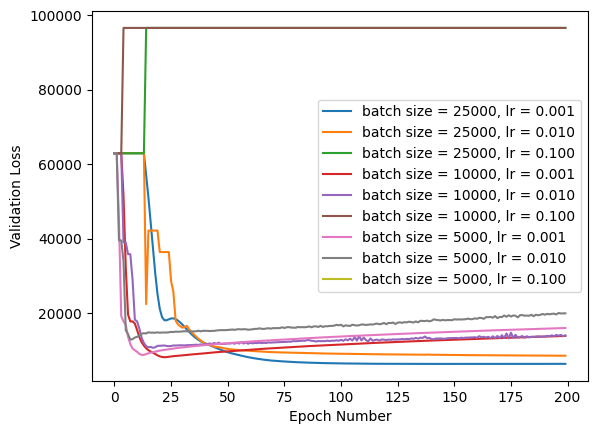

In [16]:
import matplotlib.pyplot as plt
index = 0
for i in range(len(batch_size)):
    for j in range(len(lr_list)):
        plt.plot(val_loss[index],label=f'batch size = {batch_size[i]:.0f}, lr = {lr_list[j]:.3f}')
        index += 1
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('Validation Loss')
plt.savefig('visuals/batch_lr_loss.png')
plt.show()